<a href="https://colab.research.google.com/github/ary3120-droid/myproject/blob/main/star0205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##0. 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from google.colab import drive


drive.mount('/content/drive')

path = '/content/drive/MyDrive/star/'

portfolio = pd.read_json(path + 'portfolio.json', orient='records', lines=True)
profile = pd.read_json(path + 'profile.json', orient='records', lines=True)
transcript = pd.read_json(path + 'transcript.json', orient='records', lines=True)

print("데이터 로딩 성공!")
print(f"Portfolio: {portfolio.shape}, Profile: {profile.shape}, Transcript: {transcript.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
데이터 로딩 성공!
Portfolio: (10, 6), Profile: (17000, 5), Transcript: (306534, 4)


In [2]:
# 1. 한글 폰트 설치 (나눔바른고딕)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 2. 실행 후 [런타임 다시 시작] 을 눌러주세요!

# 3. 런타임 재시작 후 아래 코드로 설정 적용
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

##1. 전처리

In [4]:
# 1. Profile 정제 (118세 행 자체를 제거)
# 팀 결정 사항: 118세 제거 시 성별/소득 결측치도 함께 제거됨
profile_clean = profile[profile['age'] != 118].copy()
profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'], format='%Y%m%d')

# 2. Transcript 정제 및 파싱
# value 컬럼에서 데이터 추출
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id') or x.get('offer id'))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount', 0))
transcript['reward'] = transcript['value'].apply(lambda x: x.get('reward', 0))
df_log = transcript.drop('value', axis=1)

# ---------------------------------------------------------
# 3. 통합 조인 (중복 방지 로직 포함)
# ---------------------------------------------------------

# [Step 1] Profile 조인 (inner join으로 118세 유저 로그까지 자동 제거)
# 팀 결정 사항: person과 id 중복 삭제 반영
df_log = pd.merge(df_log, profile_clean, left_on='person', right_on='id', how='inner')
df_log = df_log.drop('id', axis=1)

# [Step 2] Portfolio 조인 (left join으로 순수 결제 내역 보존)
# 팀 결정 사항: reward 중복 삭제 및 offer_id 일치 확인
# portfolio의 reward 컬럼 명칭을 변경하여 조인 후 충돌 방지
df_log = pd.merge(df_log, portfolio.rename(columns={'id': 'offer_id', 'reward': 'offer_reward'}),
                  on='offer_id', how='left')

# [Step 3] 최종 정리 (불필요한 중복 컬럼 제거)
# 만약 transcript의 reward와 portfolio의 offer_reward가 같다면 정리
# (결제 시점의 보상액 확인을 위해 둘 다 남기거나 하나를 선택)
print("최종 전처리 및 조인 완료!")

최종 전처리 및 조인 완료!


##2. 서비스 현황 파악 (EDA)

--- [스타벅스 서비스 주요 지표] ---
총 매출: $1,734,942
분석 대상 고객 수: 14,825명
고객당 평균 결제액 (ARPU): $117.03

--- [마케팅 노출 현황] ---
전체 결제 고객: 14,492명
쿠폰 혜택 수령 고객: 11,986명 (82.7%)
순수 자차 결제 고객: 2,506명


/tmp/ipython-input-524567950.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_log, x='event', palette='viridis', order=event_counts.index)


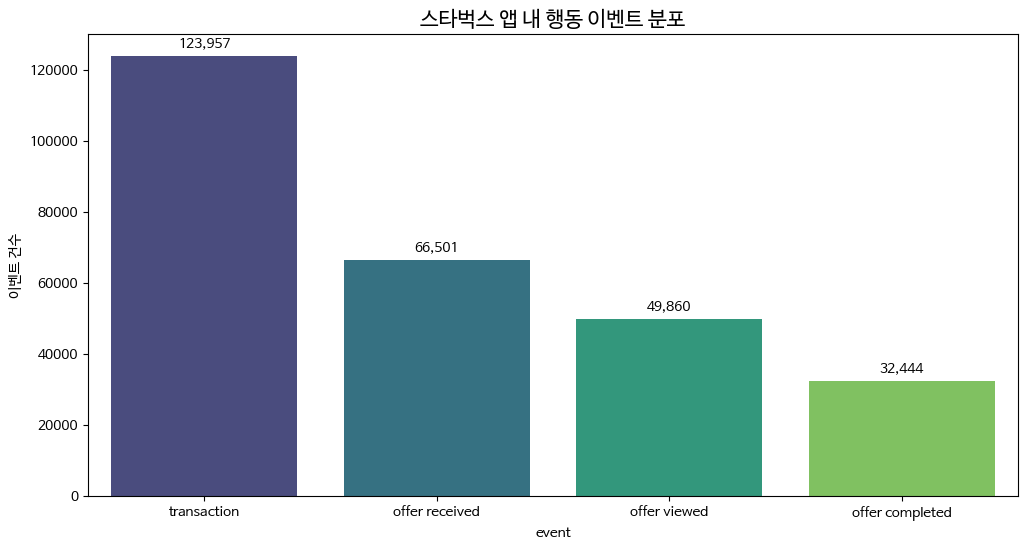

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 분석 대상 지표 요약 (118세 제외 및 전처리 완료된 데이터 기준)
# 분석 대상 고객 수 (df_log에 포함된 고유 인원)
target_users = df_log['person'].nunique()
# 전체 매출액
total_revenue = df_log['amount'].sum()
# 고객당 평균 매출 (ARPU)
avg_revenue_per_user = total_revenue / target_users

print(f"--- [스타벅스 서비스 주요 지표] ---")
print(f"총 매출: ${total_revenue:,.0f}")
print(f"분석 대상 고객 수: {target_users:,}명")
print(f"고객당 평균 결제액 (ARPU): ${avg_revenue_per_user:.2f}")

# 2. 마케팅 비용 효율성 기초 진단
# 전체 결제 인원 중 한 번이라도 쿠폰 혜택을 받은 사람의 비중 확인
users_with_coupon = df_log[df_log['event'] == 'offer completed']['person'].unique()
paying_users = df_log[df_log['event'] == 'transaction']['person'].unique()

print(f"\n--- [마케팅 노출 현황] ---")
print(f"전체 결제 고객: {len(paying_users):,}명")
print(f"쿠폰 혜택 수령 고객: {len(users_with_coupon):,}명 ({len(users_with_coupon)/len(paying_users):.1%})")
print(f"순수 자차 결제 고객: {len(paying_users) - len(users_with_coupon):,}명")

# 3. 이벤트 발생 빈도 시각화
plt.figure(figsize=(12, 6))
event_counts = df_log['event'].value_counts()
ax = sns.countplot(data=df_log, x='event', palette='viridis', order=event_counts.index)

# 막대 위에 수치 표시 (가독성 증대)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.title('스타벅스 앱 내 행동 이벤트 분포', fontsize=15)
plt.ylabel('이벤트 건수')
plt.show()

마케팅 효율성 심화 진단 (비용 낭비군 발굴)
핵심 질문인 **"쿠폰 없이도 결제했을 사람"**을 수치화하기 위한 추가 EDA 로직

In [8]:
# 1. 오퍼 완료(Completed)와 조회(Viewed) 로그 결합
viewed_logs = df_log[df_log['event'] == 'offer viewed'][['person', 'offer_id', 'time']].rename(columns={'time': 'viewed_time'})
completed_logs = df_log[df_log['event'] == 'offer completed'][['person', 'offer_id', 'time']].rename(columns={'time': 'completed_time'})

# 2. 유저별/오퍼별 타임라인 체크
check_flow = pd.merge(completed_logs, viewed_logs, on=['person', 'offer_id'], how='left')

# 3. 비용 낭비군(Waste) 정의: 조회 기록이 없거나, 결제(완료) 후 조회한 경우
waste_cases = check_flow[(check_flow['viewed_time'].isnull()) | (check_flow['viewed_time'] > check_flow['completed_time'])]

print(f"\n--- [마케팅 효율성 정밀 진단] ---")
print(f"총 보상 완료 건수: {len(check_flow):,}")
print(f"마케팅 비용 낭비 사례: {len(waste_cases):,}건")
print(f"실질적 비용 낭비율: {len(waste_cases) / len(check_flow):.1%}")


--- [마케팅 효율성 정밀 진단] ---
총 보상 완료 건수: 41,319
마케팅 비용 낭비 사례: 13,420건
실질적 비용 낭비율: 32.5%


##3. 고객 세분화 (RFM + Clustering)

In [23]:
# 1. 결제와 쿠폰 완료 데이터 시간(time) 기준으로 매칭 (데이터 정합성 보정)
completed_raw = df_log[df_log['event'] == 'offer completed'][['person', 'time', 'offer_id']]
transaction_raw = df_log[df_log['event'] == 'transaction'][['person', 'time', 'amount']]

# 병합을 통해 결제 행에 실제 쿠폰 사용 여부를 입힘
matched_tx = pd.merge(transaction_raw, completed_raw, on=['person', 'time'], how='left')

# 2. 고객별 RFM 산출
max_time = df_log['time'].max()
rfm = matched_tx.groupby('person').agg({
    'time': lambda x: max_time - x.max(),
    'amount': ['count', 'sum'],
    'offer_id': lambda x: x.isnull().sum()  # 진짜 유기적 결제(Organic) 횟수 계산
})
rfm.columns = ['Recency', 'Frequency', 'Monetary', 'Organic_Count']

# 3. 추가 지표 및 점수 부여
rfm['Organic_Rate'] = rfm['Organic_Count'] / rfm['Frequency']
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['RFM_Score'] = rfm['R_score'] + rfm['F_score'] + rfm['M_score']

print("실무형 RFM 점수 산정 완료")
display(rfm.head())

실무형 RFM 점수 산정 완료


,Recency,Frequency,Monetary,Organic_Count,Organic_Rate,R_score,F_score,M_score,RFM_Score
person,,,,,,,,,
0009655768c64bdeb2e877511632db8f,18,8,127.60,5,0.625000,5,3,4,12
0011e0d4e6b944f998e987f904e8c1e5,60,6,101.51,3,0.500000,3,2,3,8
0020c2b971eb4e9188eac86d93036a77,6,9,214.10,6,0.666667,5,3,5,13
0020ccbbb6d84e358d3414a3ff76cffd,42,12,154.05,9,0.750000,4,4,4,12
003d66b6608740288d6cc97a6903f4f0,18,18,48.34,15,0.833333,5,5,2,12


###2. K-Means 군집화 (Clustering)



단순 점수 합계보다 더 정교한 분류를 위해 머신러닝 알고리즘인 K-Means를 적용

In [22]:
# 1. 군집화용 데이터 준비 (결측치 제거 및 변수 선택)
rfm_final = rfm.dropna(subset=['Organic_Rate']).copy()
X = rfm_final[['R_score', 'F_score', 'M_score', 'Organic_Rate']]

# 2. 스케일링 및 모델 학습
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm_final['Cluster'] = kmeans.fit_predict(X_scaled)

# 3. 군집별 요약 통계 (person 컬럼이 인덱스에 있으므로 reset_index 후 계산)
cluster_summary = rfm_final.reset_index().groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Organic_Rate': 'mean',
    'RFM_Score': 'mean',
    'person': 'count'
}).rename(columns={'person': '고객수'})

print("--- [실무형 마케팅 타겟 군집별 지표] ---")
display(cluster_summary.sort_values(by='RFM_Score', ascending=False))

--- [실무형 마케팅 타겟 군집별 지표] ---


,Recency,Frequency,Monetary,Organic_Rate,RFM_Score,고객수
Cluster,,,,,,
0,55.104353,11.713377,237.623645,0.685457,12.080700,5031
3,35.862914,12.401987,56.358768,0.862553,10.197351,3020
2,126.791249,4.758432,105.257767,0.399851,7.027043,3291
1,132.005714,4.690794,29.293981,0.913972,5.340635,3150


3. 결과 시각화

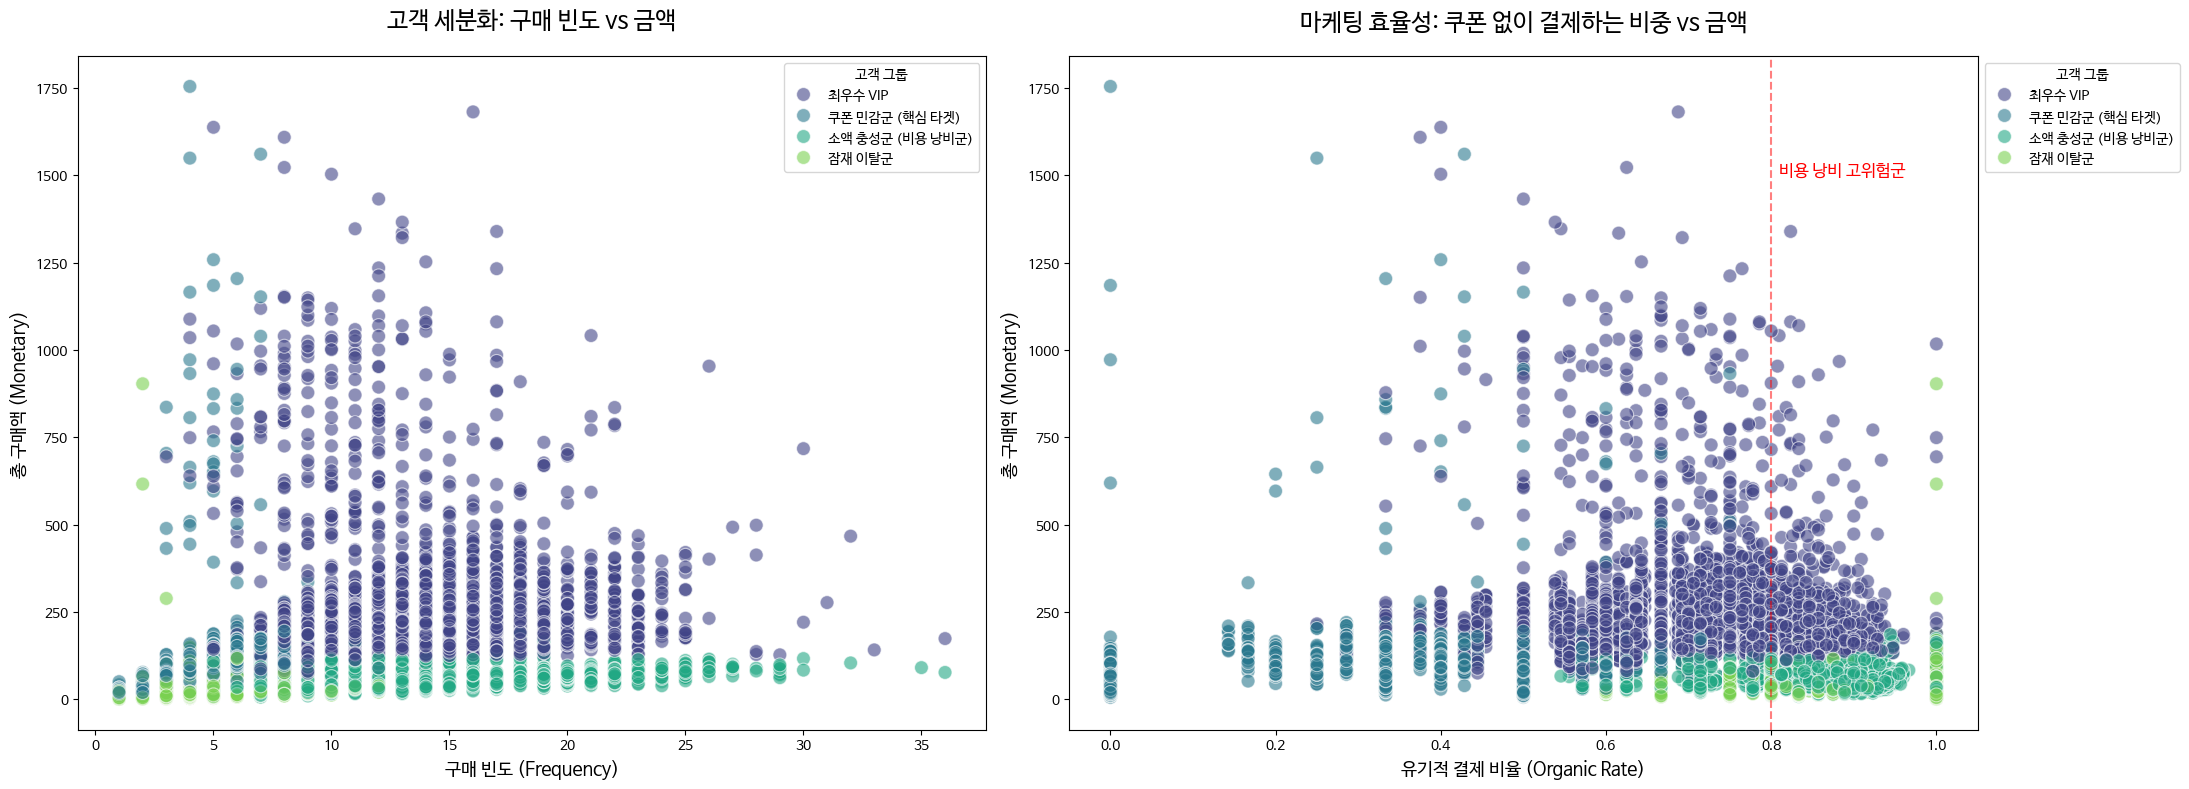

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 군집별 성격에 맞는 이름 부여 (분석 결과 기반)
# Cluster 0: 최우수 VIP, Cluster 3: 소액 충성군, Cluster 2: 쿠폰 민감군, Cluster 1: 잠재 이탈군
cluster_names = {
    0: '최우수 VIP',
    3: '소액 충성군 (비용 낭비군)',
    2: '쿠폰 민감군 (핵심 타겟)',
    1: '잠재 이탈군'
}
rfm_final['Cluster_Name'] = rfm_final['Cluster'].map(cluster_names)

# 2. 시각화 설정 (서브플롯 활용)
fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# 그래프 1: 고객 세분화 (구매 빈도 vs 총 구매액)
# 고객의 기본적인 활동성과 매출 기여도를 확인합니다.
sns.scatterplot(
    data=rfm_final, x='Frequency', y='Monetary', hue='Cluster_Name',
    ax=axes[0], palette='viridis', alpha=0.6, s=100
)
axes[0].set_title('고객 세분화: 구매 빈도 vs 금액', fontsize=17, pad=20)
axes[0].set_xlabel('구매 빈도 (Frequency)', fontsize=13)
axes[0].set_ylabel('총 구매액 (Monetary)', fontsize=13)
axes[0].legend(title='고객 그룹', bbox_to_anchor=(1, 1))

# 그래프 2: 마케팅 효율성 (유기적 결제 비중 vs 금액)
# 쿠폰 없이 결제하는 비중을 통해 마케팅 비용 절감 지점을 포착합니다.
sns.scatterplot(
    data=rfm_final, x='Organic_Rate', y='Monetary', hue='Cluster_Name',
    ax=axes[1], palette='viridis', alpha=0.6, s=100
)
axes[1].set_title('마케팅 효율성: 쿠폰 없이 결제하는 비중 vs 금액', fontsize=17, pad=20)
axes[1].set_xlabel('유기적 결제 비율 (Organic Rate)', fontsize=13)
axes[1].set_ylabel('총 구매액 (Monetary)', fontsize=13)
axes[1].legend(title='고객 그룹', bbox_to_anchor=(1, 1))

# 유기적 결제 비율 0.8 지점에 가이드라인 추가 (비용 낭비군 구분선)
axes[1].axvline(0.8, color='red', linestyle='--', alpha=0.5)
axes[1].text(0.81, 1500, '비용 낭비 고위험군', color='red', fontsize=12)

plt.tight_layout()
plt.show()

##4. 코호트 분석

In [26]:
# 시간 데이터 정규화 (24시간 = 1일)
df_log['day'] = (df_log['time'] / 24).astype(int)

# 결제 데이터와 쿠폰 완료 데이터 추출
completed_raw = df_log[df_log['event'] == 'offer completed'][['person', 'time', 'offer_id']]
transaction_raw = df_log[df_log['event'] == 'transaction'][['person', 'time', 'amount']]

# 시점 매칭을 통한 정합성 보정 (진짜 유기적 결제 판별용)
matched_tx = pd.merge(transaction_raw, completed_raw, on=['person', 'time'], how='left')
matched_tx['day'] = (matched_tx['time'] / 24).astype(int)

In [27]:
# 1. 고객별 첫 방문일(Cohort Day) 계산
matched_tx['cohort_day'] = matched_tx.groupby('person')['day'].transform('min')

# 2. 첫 방문일로부터 경과된 일수(Cohort Index) 계산
matched_tx['cohort_index'] = matched_tx['day'] - matched_tx['cohort_day']

# 3. 코호트 매트릭스 생성
cohort_counts = matched_tx.groupby(['cohort_day', 'cohort_index'])['person'].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index='cohort_day', columns='cohort_index', values='person')

# 4. 리텐션(잔존율) 비율 계산
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

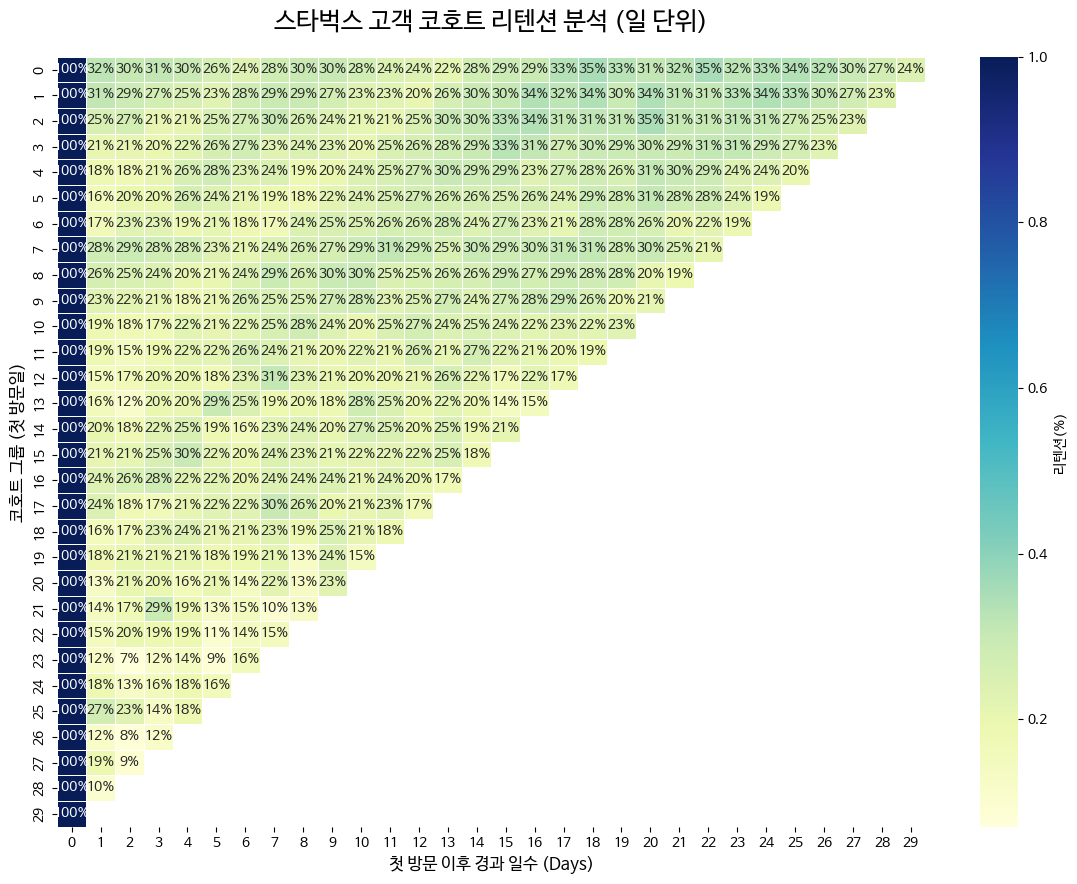

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))

# 히트맵 시각화: 수치를 %로 표기하고 눈에 편한 컬러맵 사용
sns.heatmap(retention,
            annot=True,
            fmt='.0%',
            cmap='YlGnBu',
            cbar_kws={'label': '리텐션(%)'},
            linewidths=0.5)

plt.title('스타벅스 고객 코호트 리텐션 분석 (일 단위)', fontsize=18, pad=20)
plt.xlabel('첫 방문 이후 경과 일수 (Days)', fontsize=12)
plt.ylabel('코호트 그룹 (첫 방문일)', fontsize=12)
plt.show()

### ⑤ 이탈 예측 및 타겟팅 모델링

**1. 이탈 예측용 피처 엔지니어링 (Feature Engineering)**

머신러닝 모델이 학습할 수 있도록 고객별 데이터를 정제합니다.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. 타겟 라벨(Label) 생성: 최근 7일간 방문 기록이 없으면 이탈(1), 있으면 유지(0)로 정의
# 스타벅스 데이터의 마지막 시간을 기준으로 판단합니다.
cutoff_time = df_log['time'].max() - (7 * 24)
rfm_final['Churn'] = rfm_final['Recency'].apply(lambda x: 1 if x > (7 * 24) else 0)

# 2. 학습에 사용할 피처 선택
# RFM 점수와 우리가 만든 유기적 결제 비율이 핵심입니다.
X = rfm_final[['R_score', 'F_score', 'M_score', 'Organic_Rate', 'Recency', 'Frequency', 'Monetary']]
y = rfm_final['Churn']

# 3. 데이터 분할 (학습용 80%, 테스트용 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("데이터셋 준비 완료 (Feature Engineering)")

데이터셋 준비 완료 (Feature Engineering)


**2. 모델 학습 및 성능 평가**

랜덤 포레스트(Random Forest) 모델을 사용하여 이탈 가능성을 예

--- [이탈 예측 모델 성능 평가] ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2529
           1       1.00      1.00      1.00       370

    accuracy                           1.00      2899
   macro avg       1.00      1.00      1.00      2899
weighted avg       1.00      1.00      1.00      2899



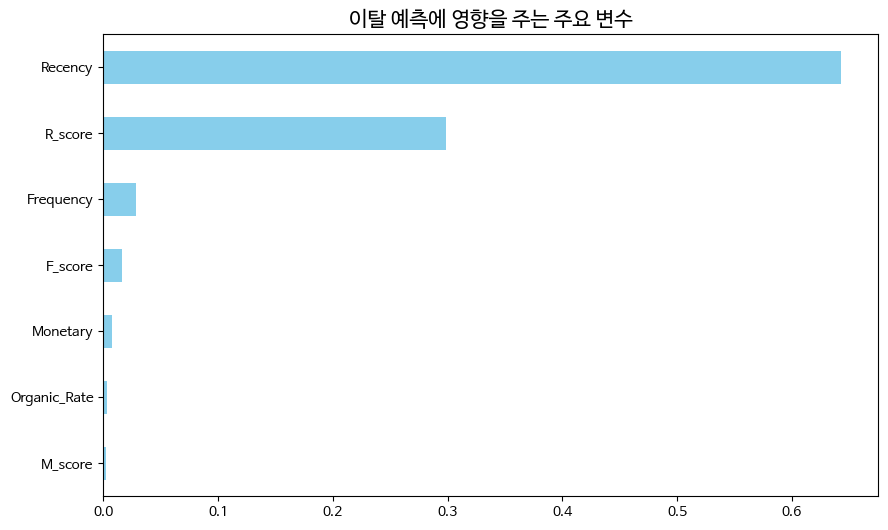

In [30]:
# 1. 모델 생성 및 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 2. 예측 및 평가
y_pred = model.predict(X_test)
print("--- [이탈 예측 모델 성능 평가] ---")
print(classification_report(y_test, y_pred))

# 3. 피처 중요도 시각화
importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
importances.sort_values().plot(kind='barh', color='skyblue')
plt.title('이탈 예측에 영향을 주는 주요 변수', fontsize=15)
plt.show()

3. 실무 활용: 타겟 고객 추출 (Actionable Insights)

In [31]:
# 전체 고객에 대해 이탈 확률 계산
rfm_final['Churn_Probability'] = model.predict_proba(X)[:, 1]

# 마케팅 효율화 타겟 조건:
# 1) 이탈 확률이 70% 이상이고
# 2) 유기적 결제 비율이 0.5 미만인 고객 (쿠폰에 반응할 사람)
target_customers = rfm_final[
    (rfm_final['Churn_Probability'] > 0.7) &
    (rfm_final['Organic_Rate'] < 0.5)
]

print(f"전략적 쿠폰 발송 대상자: {len(target_customers)}명")
display(target_customers.head())

전략적 쿠폰 발송 대상자: 366명


,Recency,Frequency,Monetary,Organic_Count,Organic_Rate,R_score,F_score,M_score,RFM_Score,Cluster,Cluster_Name,Churn,Churn_Probability
person,,,,,,,,,,,,,
01925607d99c460996c281f17cdbb9e2,204,3,80.10,0,0.0,1,1,3,5,2,쿠폰 민감군 (핵심 타겟),1,1.00
026876bc8c6a4e0c8e330342c92cc844,348,1,26.38,0,0.0,1,1,1,3,2,쿠폰 민감군 (핵심 타겟),1,0.97
036e4bedca2045afad50fda2d3b505ab,258,2,49.70,0,0.0,1,1,2,4,2,쿠폰 민감군 (핵심 타겟),1,1.00
048bf07732684843b6334f8f157af033,258,1,15.23,0,0.0,1,1,1,3,2,쿠폰 민감군 (핵심 타겟),1,1.00
04ea45ec66574a618b0918834ee08fed,204,2,42.04,0,0.0,1,1,2,4,2,쿠폰 민감군 (핵심 타겟),1,1.00
